In [1]:
%load_ext autoreload

%autoreload 2

In [299]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as tfk
from sklearn.model_selection import train_test_split
from validation.metrics import OME, MSE
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, PowerTransformer
from MODELS.ViscNN import create_ViscNN, create_ViscNN_concat, create_ViscNN_phys,predict_all_cv, create_ViscNN_concat_HP,  create_ViscNN_phys_HP
from validation.tests import viscNN_LC,get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test, small_shear_test
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
from data_tools.data_viz import val_epochs, calc_slopes_Mw
import keras.backend as K
import keras
pd.options.mode.chained_assignment = None  # default='warn'

In [177]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

In [162]:
data = pd.read_excel('Data/full_data_2022-01-19_MOD.xlsx')
data.columns = [str(c) for c in data.columns]

In [163]:
shear_samps, shear_ids = get_shear_samples(data.copy())

2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [164]:
shear_samps.loc[shear_samps['Shear_Rate'] == 0].head(100)

,INDEX,SAMPLE_ID,SMILES,Polymer,Mn,Mw,PDI,PDI (zw),Temperature,Shear_Rate,...,bfp_79,bfp_210,bfp_482,PID 1,PID 2,coPID,Weight 1,Weight 2,Frequency,INDEX.1
353,373,260.0,[*]Sc1ccc([*])cc1,poly(p-phenylene sulfide),NaN,4.806180,NaN,NaN,300.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,383,261.0,[*]Sc1ccc([*])cc1,poly(p-phenylene sulfide),NaN,4.748188,NaN,NaN,300.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,393,262.0,[*]Sc1ccc([*])cc1,poly(p-phenylene sulfide),NaN,4.643453,NaN,NaN,300.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749,807,428.0,[*]Oc1ccc(OC(=O)c2ccc(OCCCCCCCCCCOc3ccc(C([*])...,"poly([2-(phenylsulfonyl)hydroquinone]-alt-{4,4...",NaN,4.653213,NaN,NaN,180.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
758,816,429.0,[*]Oc1ccc(OC(=O)c2ccc(OCCCCCCCCCCOc3ccc(C([*])...,"poly([2-(phenylsulfonyl)hydroquinone]-alt-{4,4...",NaN,4.653213,NaN,NaN,185.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,828,430.0,[*]Oc1ccc(OC(=O)c2ccc(OCCCCCCCCCCOc3ccc(C([*])...,"poly([2-(phenylsulfonyl)hydroquinone]-alt-{4,4...",NaN,4.653213,NaN,NaN,191.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
782,840,431.0,[*]Oc1ccc(OC(=O)c2ccc(OCCCCCCCCCCOc3ccc(C([*])...,"poly([2-(phenylsulfonyl)hydroquinone]-alt-{4,4...",NaN,4.653213,NaN,NaN,196.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
990,1053,588.0,[*]CCCCCCCCCCNC(=O)CCCCCCCCC(=O)N[*],"poly[(decane-1,10-diamine)-alt-(decanedioic ac...",NaN,4.127105,NaN,NaN,220.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,1217,679.0,[*]O[Si]([*])(C)C,poly(dimethylsiloxane),NaN,5.238046,NaN,NaN,23.0,0.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1396,1526,703.0,"[*]C[*], [*]CC([*])OC(C)=O","polyethene, poly(vinyl acetate)",30000.0,4.778151,NaN,NaN,210.0,0.0,...,0,0,0,NaN,NaN,NaN,0.72,0.28,NaN,NaN


In [165]:
Mw_samps, mw_ids = get_Mw_samples(data.copy()) 

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158

In [166]:
OG_fp = []
for c in data.columns:
    if isinstance(c, str):
        if 'fp' in c:
            OG_fp.append(c)
len(OG_fp)

217

In [167]:
do_pca = False
if do_pca:
    data, fp_cols, pca = fp_PCA(data, 17, cols = OG_fp)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
else:
    fp_cols = OG_fp
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']

In [168]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
        #data = data.drop([i])

In [321]:
#cols.remove('Shear_Rate')
filtered_data = data.loc[:, cols + ['Polymer', 'SHEAR', 'ZERO_SHEAR', 'log_Shear_Rate']].dropna(subset = ['Mw', 'Shear_Rate'])
#X_tot = np.array(filtered_data.filter(fp_cols + ['SHEAR', 'ZERO_SHEAR']))
scaler = MinMaxScaler(copy = False)
X_tot = np.array(scaler.fit(filtered_data.filter(fp_cols)).transform(filtered_data.filter(fp_cols)))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

In [322]:
logMw = np.array(filtered_data['Mw']).reshape((tot_samples,1))
log_shear = np.array(filtered_data['log_Shear_Rate']).reshape((tot_samples,1))
shear = np.array(filtered_data['Shear_Rate']).reshape((tot_samples,1))
Temp = np.array(filtered_data['Temperature']).reshape((tot_samples,1))
Temp = 1/(Temp+273.15)

#y_scaler = MinMaxScaler(copy = False)
#y_scaler.fit(Y_tot).transform(Y_tot);
#S_scaler = MaxAbsScaler().fit(log_shear)
#log_shear = S_scaler.transform(log_shear)
T_scaler = MinMaxScaler().fit(Temp)
Temp = T_scaler.transform(Temp);
M_scaler = MinMaxScaler().fit(logMw)
logMw = M_scaler.transform(logMw);
S_trans = PowerTransformer(standardize = False).fit(shear)
S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
shear = S_scaler.transform(S_trans.transform(shear))
#shear = S_scaler.transform((shear))
#gpr_Mcr, mcr_cv_error = Mcr_gpr_train(OG_fp, None, M_scaler, scaler, transform = False)

Learning Curve

In [171]:
#viscNN_LC(create_ViscNN_concat, X_tot, Y_tot,logMw, shear, Temp)

In [323]:
XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test, train_ind, test_ind = train_test_split(X_tot, Y_tot,logMw, shear, Temp, range(tot_samples), test_size= 0.1)

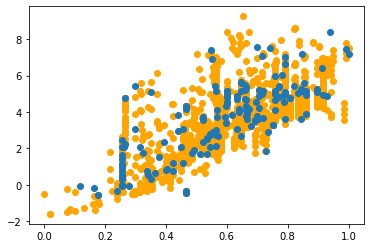

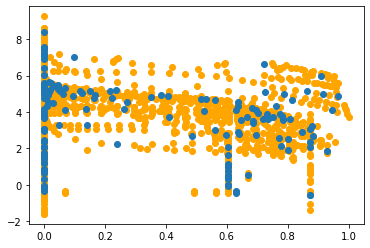

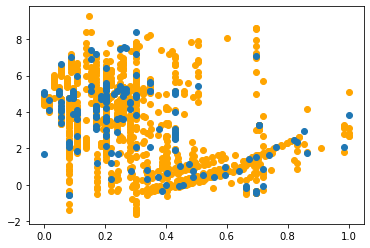

In [324]:
plt.scatter(M, yy, c = 'orange')
plt.scatter(M_test, y_test)

plt.figure()
plt.scatter(S, yy, c = 'orange')
plt.scatter(S_test, y_test)

plt.figure()
plt.scatter(T, yy, c = 'orange')
plt.scatter(T_test, y_test)

In [180]:
models, history, gpr_models, gp_cv  = crossval_compare([create_ViscNN_concat, create_ViscNN_phys], XX, yy, M=M, S=S, T=T, S_trans = S_trans, S_scaler = S_scaler, M_scaler = M_scaler, verbose = 1, gpr_model = create_GPR, epochs = 600)

Trained fold 1 ...
CV Error create_ViscNN_concat: 0.2598940134048462
CV Error create_ViscNN_phys: 0.25960615277290344
CV Error GPR: tf.Tensor(0.12834312, shape=(), dtype=float32)
Trained fold 2 ...
CV Error create_ViscNN_concat: 0.28053420782089233
CV Error create_ViscNN_phys: 0.25819408893585205
CV Error GPR: tf.Tensor(0.19741613, shape=(), dtype=float32)
Trained fold 3 ...
CV Error create_ViscNN_concat: 0.23343825340270996
CV Error create_ViscNN_phys: 0.21217581629753113
CV Error GPR: tf.Tensor(0.106713854, shape=(), dtype=float32)
Trained fold 4 ...
CV Error create_ViscNN_concat: 0.26604288816452026
CV Error create_ViscNN_phys: 0.21585585176944733
CV Error GPR: tf.Tensor(0.111384496, shape=(), dtype=float32)
Trained fold 5 ...
CV Error create_ViscNN_concat: 0.2769683003425598
CV Error create_ViscNN_phys: 0.29950398206710815
CV Error GPR: tf.Tensor(0.13737534, shape=(), dtype=float32)
Trained fold 6 ...
CV Error create_ViscNN_concat: 0.2661529779434204
CV Error create_ViscNN_phys: 0.

In [326]:
models_f, history_f, gpr_models_f, gp_cv_f  = crossval_compare([create_ViscNN_concat, create_ViscNN_phys], X_tot, Y_tot, M=logMw, S=shear, T=Temp, S_trans = S_trans, S_scaler = S_scaler, M_scaler = M_scaler, verbose = 1, gpr_model = create_GPR, epochs = 600)

Trained fold 1 ...
CV Error create_ViscNN_concat: 0.24933888018131256
CV Error create_ViscNN_phys: 0.30637821555137634
CV Error GPR: tf.Tensor(0.13051215, shape=(), dtype=float32)
Trained fold 2 ...
CV Error create_ViscNN_concat: 0.19395174086093903
CV Error create_ViscNN_phys: 0.22535182535648346
CV Error GPR: tf.Tensor(0.092650406, shape=(), dtype=float32)
Trained fold 3 ...
CV Error create_ViscNN_concat: 0.2274760752916336
CV Error create_ViscNN_phys: 0.24336428940296173
CV Error GPR: tf.Tensor(0.1375394, shape=(), dtype=float32)
Trained fold 4 ...
CV Error create_ViscNN_concat: 0.24782314896583557
CV Error create_ViscNN_phys: 0.2770831882953644
CV Error GPR: tf.Tensor(0.115534715, shape=(), dtype=float32)
Trained fold 5 ...
CV Error create_ViscNN_concat: 0.25497353076934814
CV Error create_ViscNN_phys: 0.2822765111923218
CV Error GPR: tf.Tensor(0.12687278, shape=(), dtype=float32)
Trained fold 6 ...
CV Error create_ViscNN_concat: 0.25969424843788147
CV Error create_ViscNN_phys: 0.2

In [101]:
model_num = 4

Test OME:0.21915984


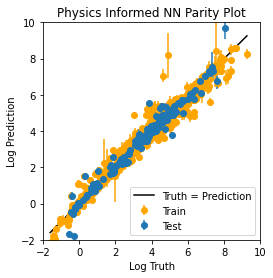

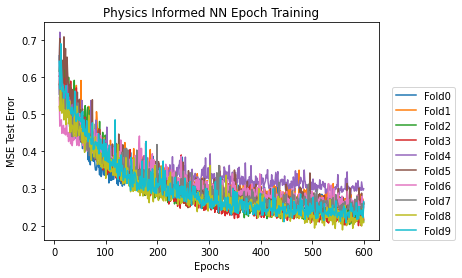

In [182]:
m_P = models[1][model_num]

test_pred, test_var,_ = predict_all_cv(models[1],[X_test, M_test, S_test, T_test])
train_pred, train_var,_ = predict_all_cv(models[1],[XX, M, S, T])
plt.errorbar(yy,train_pred, yerr = train_var, c = 'orange', fmt = 'o')
plt.errorbar(y_test ,test_pred, yerr= test_var, fmt =  'o')

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Physics Informed NN Parity Plot')
val_epochs(history[1], name = 'Physics Informed NN')

print("Test OME:" + str(OME(np.array(test_pred),[y[0] for y in y_test]).numpy()))

Test OME:0.21125212


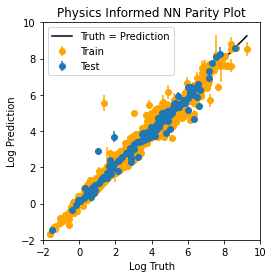

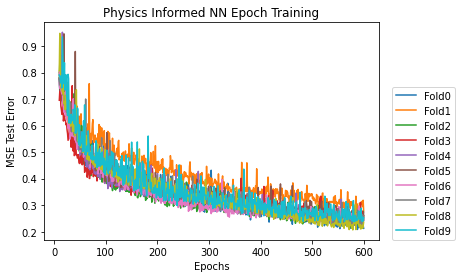

In [103]:
m_P = models[0][model_num]

test_pred, test_var,_ = predict_all_cv(models[0],[X_test, M_test, S_test, T_test])
train_pred, train_var,_ = predict_all_cv(models[0],[XX, M, S, T])
plt.errorbar(yy,train_pred, yerr = train_var, c = 'orange', fmt = 'o')
plt.errorbar(y_test ,test_pred, yerr= test_var, fmt =  'o')

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Physics Informed NN Parity Plot')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
val_epochs(history[0], name = 'Physics Informed NN')

print("Test OME:" + str(OME(np.array(test_pred),[y[0] for y in y_test]).numpy()))

In [41]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
train_df[train_df['BAD_PRED'] == True].sort_index().to_excel('NP_Bad_pred_1_19_2022.xlsx')

0.35321355791622044


Test OME:0.21014048


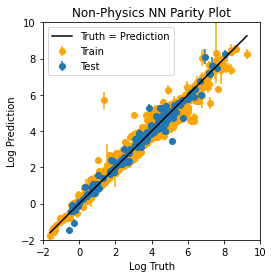

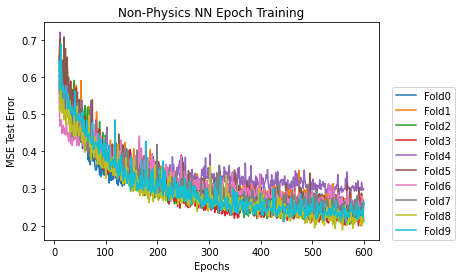

In [183]:
m_NP = models[0][model_num]
# test_pred =  m_NP.predict([X_test, M_test, S_test, T_test, gr_Mcr_test])
# train_pred = m_NP.predict([XX, M, S, T, gr_Mcr])
test_pred, test_var, _ = predict_all_cv(models[0],[X_test, M_test, S_test, T_test])
train_pred, train_var, _ = predict_all_cv(models[0],[XX, M, S, T])
#plt.scatter(yy, train_pred, c = 'orange')
#plt.scatter(y_test, test_pred)
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-', zorder = 10)
plt.errorbar(yy,train_pred, yerr = train_var, c = 'orange', fmt = 'o')
plt.errorbar(y_test ,test_pred, yerr= test_var, fmt =  'o')


plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Non-Physics NN Parity Plot')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
val_epochs(history[1], name = 'Non-Physics NN')

print("Test OME:" + str(OME(test_pred, [y[0] for y in y_test]).numpy()))


In [17]:
#gpr_model = train_GPR(XX, yy, M, S, T)
gpr_model = gpr_models[model_num]

Test MSE:0.1625343048118242
Test OME:tf.Tensor(0.12710758, shape=(), dtype=float32)
(160,)


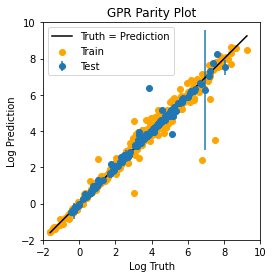

In [184]:
gpr_model = gpr_models[5] 
X_ = np.concatenate((X_test, M_test, S_test, T_test), axis = 1)
X_train = np.concatenate((XX, M, S, T), axis = 1)
test_pred, var = gpr_model.predict_y(X_)
## generate 10 samples from posterior
error =  [i[0] for i in np.array(var).tolist()]
print("Test MSE:" + str(MSE(test_pred, y_test)))
print("Test OME:" + str(OME(tf.cast(test_pred, tf.float32), y_test)))

high_var_test = np.where(np.array(var) > 10)
test_pred = np.delete(np.array(test_pred), high_var_test)
print(test_pred.shape)
y_test_new = np.delete(np.array(y_test), high_var_test)
var = np.delete(np.array(var), high_var_test)
# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
train_pred, var_train = gpr_model.predict_y(X_train)
plt.scatter(yy, train_pred, c = 'orange')
plt.errorbar(y_test_new, test_pred, var, fmt = 'o')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.legend(['Truth = Prediction', 'Train','Test'])
plt.title('GPR Parity Plot')
plt.show()

In [72]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['BAD_PRED'] == True]
test_df.reset_index().loc[error.index(max(error))]

ValueError: Length of values (152) does not match length of index (155)

In [67]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
train_df[train_df['BAD_PRED'] == True]

0.34246501152543185


,afp_C4_C4_C4,afp_C4_C4_H1,afp_H1_C4_H1,bfp_267,bfp_282,bfp_289,bfp_304,bfp_315,bfp_334,bfp_349,...,Temperature,Shear_Rate,Melt_Viscosity,Polymer,SHEAR,ZERO_SHEAR,log_Shear_Rate,Y_pred,Error,BAD_PRED
1544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493218,0.570096,...,260.0,935.307371,2.139073,"Poly(hexano-6-lactam), PPTA",1,0,2.970954,2.845784,0.706711,True
261,0.266667,0.466667,0.466667,0.533333,0.000000,0.200000,1.400000,0.000000,0.533333,0.533333,...,220.0,89.526571,4.423077,poly(methyl methacrylate),1,0,1.951952,3.929518,0.493559,True
1165,0.149429,0.448286,0.074714,0.000000,0.298857,0.224143,0.896571,0.149429,0.448286,0.489143,...,200.0,0.097696,4.552494,"polystyrene, polyacrylonitrile",1,0,-1.010123,4.170946,0.381547,True
1089,0.134643,0.403929,0.067321,0.000000,0.269286,0.201964,0.807857,0.134643,0.403929,0.495714,...,170.0,0.000000,3.214844,"polystyrene, polyacrylonitrile",0,1,0.000000,3.880512,0.665668,True
194,0.125000,0.375000,0.062500,0.000000,0.250000,0.187500,0.750000,0.125000,0.375000,0.500000,...,200.0,548.441658,2.209302,polystyrene,1,0,2.739130,2.872448,0.663145,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.181571,0.544714,0.090786,0.000000,0.363143,0.272357,1.089429,0.181571,0.544714,0.474857,...,200.0,0.390965,5.426735,"polystyrene, polyacrylonitrile",1,0,-0.407862,4.978222,0.448514,True
875,0.151515,0.484848,0.181818,0.000000,0.000000,0.545455,0.636364,0.000000,0.545455,0.363636,...,205.0,0.000000,3.399674,"poly[(2,2,3,3,4,4-hexafluoropentane-1,5-diol)-...",0,1,0.000000,3.810134,0.410461,True
183,0.333333,0.666667,0.166667,0.000000,0.000000,0.500000,1.000000,0.000000,0.666667,0.333333,...,210.0,0.000000,5.000000,poly(vinylidene fluoride),0,1,0.000000,5.585200,0.585200,True
1329,0.273810,0.821429,0.161905,0.033333,0.547619,0.410714,1.642857,0.273810,0.821429,0.435714,...,220.0,38.940893,3.532110,"polyacrylonitrile, Poly(methyl acrylate)",1,0,1.590406,4.012979,0.480869,True


In [271]:
tuner = kt.Hyperband(create_ViscNN_phys_HP, objective='val_loss',
                     max_epochs=20,
                     factor=3, project_name = 'phys_NN_0')

tuner.search([XX, M, S, T], yy,
             validation_data= ([X_test, M_test, S_test, T_test], y_test),
             epochs=20,
             batch_size = 16,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 30 Complete [00h 00m 06s]
val_loss: 0.7525761723518372

Best val_loss So Far: 0.6201639771461487
Total elapsed time: 00h 01m 54s
INFO:tensorflow:Oracle triggered exit


In [272]:
tuner.get_best_hyperparameters(num_trials = 1)[0].values

{'layer_1': 150,
 'layer_2': 90,
 'dropout_1': 0.0,
 'dropout_2': 0.1,
 'Mcr_calc': 3,
 'dec_layer': 5,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': 'b60c82cdb3bf5065652b1c6f45e5bf78'}

In [263]:
tuner.get_best_hyperparameters(num_trials = 1)[0].values

{'layer_1': 150,
 'layer_2': 120,
 'dropout_1': 0.1,
 'dropout_2': 0.1,
 'Mcr_calc': 2,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
tuner = kt.Hyperband(
        create_ViscNN_concat_HP,
        objective='val_loss',
        max_epochs=400,
        seed=10,
        factor=3,
        hyperband_iterations=4,
        directory=f'hp_search',
        project_name= 'create_ViscNN_concat3'
        )

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    factor=0.8,
    monitor="val_loss",
    verbose=1,
)
    
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

# Create an instance of the model
tuner.search([XX, M, S, T], yy,
             validation_data= ([X_test, M_test, S_test, T_test], y_test),
            epochs=400,
            callbacks=[earlystop, reduce_lr],
            verbose=1
            )

In [ ]:
k_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('log_k_1').output)
tau_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('tau').output)
alpha_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('alpha').output)
n_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('n').output)
crit_shear_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('crit_shear').output)
layer_name2 = 'zero_shear_visc'
z_shear_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer(layer_name2).output)

In [389]:
extrap_tests = Mw_test(Mw_samps, mw_ids[8])

    INDEX  SAMPLE_ID              SMILES      Polymer  Mn        Mw  PDI  \
0     104       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  4.929419  NaN   
1     105       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  4.332438  NaN   
2     106       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  4.204120  NaN   
3     107       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  4.089905  NaN   
4     108       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  3.959041  NaN   
5     109       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  3.859138  NaN   
6     110       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  3.748188  NaN   
7     111       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  3.682145  NaN   
8     112       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  3.633468  NaN   
9     113       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  3.549003  NaN   
10    114       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  3.531479  NaN   
11    115       12.0  [*]CC([*])c1ccccc1  polystyrene NaN  3.472756  NaN   

    PDI (zw

In [390]:
XX_ex, OH, M_ex_og,S_ex_og,T_ex = extrap_tests['data_in']
#print(extrap_tests[samp_num]['tests'])
Mw_ex = extrap_tests['exp'][0]
log_visc_ex = extrap_tests['exp'][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform(S_trans.transform(S_ex_og)) #(
T_ex = T_scaler.transform(1/(T_ex+273.15))

Text(0.5, 1.0, 'GPR Extrapolation')

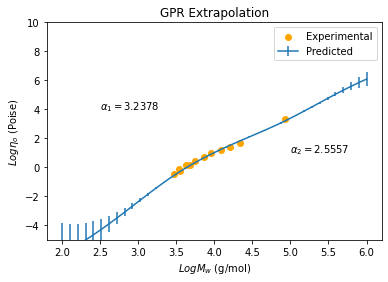

In [397]:
test_pred, var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex, T_ex), axis = 1))
plt.figure()
plt.xlabel(r'$Log M_w$ (g/mol)')
plt.ylabel(r'$Log \eta_o$ (Poise)')
plt.ylim(-5, 10)
a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
plt.text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
plt.text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
#plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, [i[0] for i in np.array(var).tolist()], fmt = '-')
plt.legend(['Experimental','Predicted'])
plt.title('GPR Extrapolation')

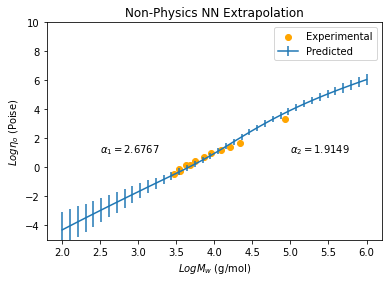

In [398]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex])

plt.figure()
plt.title('Non-Physics NN Extrapolation')
plt.xlabel(r'$Log M_w$ (g/mol)')
plt.ylabel(r'$Log \eta_o$ (Poise)')
a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
plt.text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
plt.text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.ylim(-5, 10)
#plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var)
plt.legend(['Experimental','Predicted'])

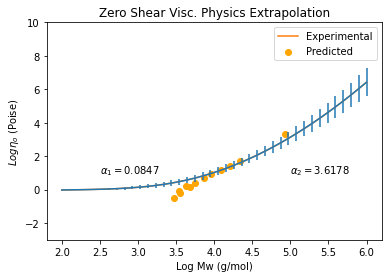

In [395]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
test_pred, test_var, tot_pred = predict_all_cv(models_f[1],[XX_ex, M_ex, S_ex, T_ex])
plt.figure()
plt.title('Zero Shear Visc. Physics Extrapolation')
plt.xlabel('Log Mw (g/mol)')
plt.ylabel(r'$Log \eta_o$ (Poise)')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var)
plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
plt.text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
plt.text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
plt.ylim(-3, 10)
plt.legend(['Experimental','Predicted'])
#plt.plot([4,6], [2.5, 2.5+(3.4*2)])
#print(k_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
#print(tau_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
#print(alpha_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
#print(n_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))

In [419]:
do_pca = False
samp_num = shear_ids[3]
s_test = shear_test(shear_samps, samp_num)
XX_ex, M_ex,S_ex,T_ex = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = s_test['known'][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
M_ex = M_scaler.transform(M_ex)
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(1/(T_ex+273.15))
y_ax = (2,7)
temp_test = False

   INDEX  SAMPLE_ID                SMILES                    Polymer  Mn  \
0    268      211.0  [*]CC([*])(C)C(=O)OC  poly(methyl methacrylate) NaN   
1    269      211.0  [*]CC([*])(C)C(=O)OC  poly(methyl methacrylate) NaN   
2    270      211.0  [*]CC([*])(C)C(=O)OC  poly(methyl methacrylate) NaN   
3    271      211.0  [*]CC([*])(C)C(=O)OC  poly(methyl methacrylate) NaN   
4    272      211.0  [*]CC([*])(C)C(=O)OC  poly(methyl methacrylate) NaN   
5    273      211.0  [*]CC([*])(C)C(=O)OC  poly(methyl methacrylate) NaN   
6    274      211.0  [*]CC([*])(C)C(=O)OC  poly(methyl methacrylate) NaN   
7    275      211.0  [*]CC([*])(C)C(=O)OC  poly(methyl methacrylate) NaN   

         Mw  PDI  PDI (zw)  Temperature   Shear_Rate  ...  bfp_79 bfp_210  \
0  4.778151  NaN       NaN        220.0    39.591103  ...       0       0   
1  4.778151  NaN       NaN        220.0    79.597770  ...       0       0   
2  4.778151  NaN       NaN        220.0   319.524751  ...       0       0   
3  4.77

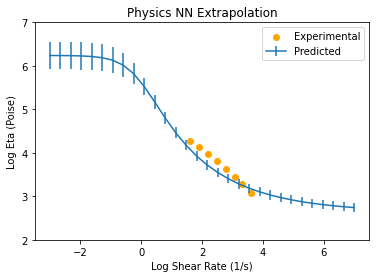

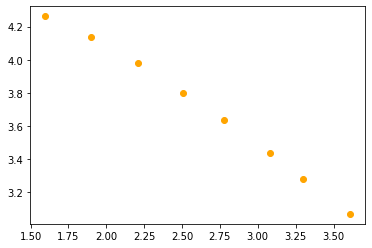

In [420]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
test_pred, test_var,_ = predict_all_cv(models_f[1],[XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in np.log10(S_ex)]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]])])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Log Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
#plt.plot(np.log10(S_ex[:-1]), test_pred[:-1])
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Predication at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
     plt.legend(['Experimental','Predicted'])
plt.title('Physics NN Extrapolation')
plt.ylim(*y_ax)

plt.figure()
plt.scatter(shear_exp, log_visc_exp, c = 'orange')

#print(params_layer([XX_ex, M_ex, S_ex_trans, T_ex]))
#z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex])
#print(crit_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(tau_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(n_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))

(2.0, 7.0)

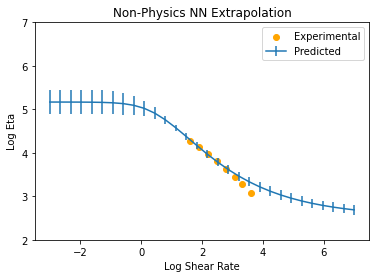

In [421]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
test_pred, test_var,_ = predict_all_cv(models_f[0], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in np.log10(S_ex)]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Non-Physics NN Extrapolation')

if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[0],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Log Shear Rate')
plt.ylabel('Log Eta')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])
#plt.plot(np.log10(S_ex), test_pred)
plt.ylim(*y_ax)

[0.09748400589514411, 0.09745552026493393, 0.09740031243229602, 0.09731569236058896, 0.09730468131193654, 0.09806743979773508, 0.10289786274619367, 0.12323938522432037, 0.18181843197245634, 0.2747910285050961, 0.30838105012103206, 0.21663153897699466, 0.09781338183995253, 0.0435466594806831, 0.03433840732923749, 0.03341252144565538, 0.032881141237414875, 0.03266563869034706, 0.03278094871516452, 0.03446582367493584, 0.03996363954064159, 0.05091852860287866, 0.06759732200941976, 0.08917147585938473, 0.1142711176787477, 0.1414251694732092, 0.16931659031462992, 0.19689170737381595, 0.22337949308999022, 0.24826452784124037]


(2.0, 7.0)

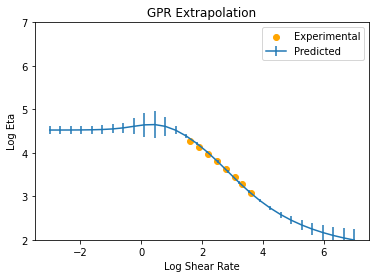

In [422]:
test_pred, test_var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
plt.figure()
plt.title('GPR Extrapolation')
plt.errorbar(shear, test_pred, yerr= [i[0] for i in np.array(test_var).tolist()])
plt.xlabel('Log Shear Rate')
plt.ylabel('Log Eta')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
print([i[0] for i in np.array(test_var).tolist()])
plt.legend(['Experimental','Predicted'])
plt.ylim(*y_ax)

Shear with Low and Zero Shear Rates

In [355]:
low_shear_samps = shear_samps.copy()
for samp in shear_ids:
    if np.prod(low_shear_samps.loc[low_shear_samps['SAMPLE_ID'] == samp, 'Shear_Rate']) != 0:
        low_shear_samps = low_shear_samps.drop(low_shear_samps.loc[low_shear_samps['SAMPLE_ID'] == samp].index, axis = 0)
low_shear_ids = list(low_shear_samps.agg({'SAMPLE_ID': 'unique'})[0])

In [356]:
low_shear_samps.index

Int64Index([ 342,  343,  344,  345,  346,  347,  348,  349,  350,  351,
            ...
            1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396],
           dtype='int64', length=143)

In [364]:
samp_num = low_shear_ids[5]
s_test = small_shear_test(low_shear_samps, samp_num)
XX_ex, M_ex,S_ex,T_ex = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = s_test['known'][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
M_ex = M_scaler.transform(M_ex)
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(1/(T_ex+273.15))
temp_test = False

[0.03042978522336221, 0.030428489532532917, 0.030426185155989112, 0.030419808529086163, 0.030402337665663533, 0.03035579318515553, 0.030241459037111236, 0.030024330465729117, 0.029929376729907427, 0.030837640670377704, 0.040436426172750624]


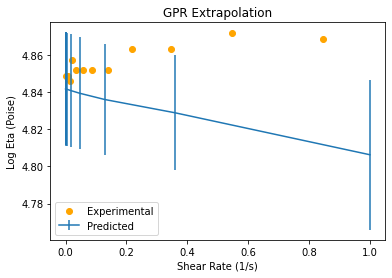

In [365]:
test_pred, test_var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
shear = [s[0] for s in S_ex]


plt.figure()
plt.title('GPR Extrapolation')
plt.errorbar(shear, test_pred, yerr= [i[0] for i in np.array(test_var).tolist()])
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
print([i[0] for i in np.array(test_var).tolist()])
plt.legend(['Experimental','Predicted'])

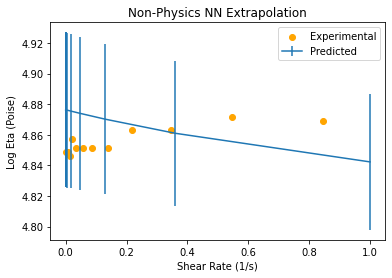

In [366]:
test_pred, test_var,_ = predict_all_cv(models[0], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in S_ex]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Non-Physics NN Extrapolation')

if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])

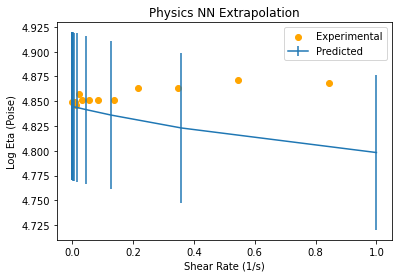

In [367]:
test_pred, test_var,_ = predict_all_cv(models[1], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in S_ex]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Physics NN Extrapolation')

if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])

START TRAINING GPR FOR Mcr

In [94]:
me_data = pd.read_excel('Data/EntanglementMW_fp.xlsx')
fp = me_data[[c for c in me_data.columns if 'fp' in c]]
fp[[c for c in OG_fp if c not in fp]] = 0
fp = fp.drop(columns = [c for c in fp if c not in OG_fp])
y = M_scaler.transform(np.log10(np.array(me_data['Me']*2)).reshape(-1,1))
X_me = scaler.transform((pca.transform(fp[OG_fp]))) if do_pca else scaler.transform(((fp[OG_fp])))

C:\Users\ayush\Documents\Melt_Viscosity\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [95]:
x_me, x_me_test, y_me, y_me_test = train_test_split(X_me, y, test_size = 0.1)

In [96]:
gpr_Mcr = create_GPR(X_me, y)

In [17]:
tf.saved_model.save(gpr_Mcr, 'models')

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [18]:
gpr = tf.saved_model.load('models')

In [ ]:
gpr.predict_y(x_me)

In [24]:
trial_scale = MinMaxScaler(copy = False)

In [25]:
arr = np.array([[1,1,1], [1,2,3]])

In [26]:
trial_scale.fit(arr).transform(arr)

array([[0., 0., 0.],
       [0., 1., 1.]])